# Train on all patients

## Leave One Out

In [12]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap
import xgboost as xgb
import neurokit2 as nk

In [5]:
extension = 'csv'
path = 'C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/'
model_name = 'brazil_model_features_2.json'
# SC = StandardScaler()
patients_dirs = [x[0] for x in os.walk(path)]
del patients_dirs[0]

# Initialize the classifier
model = XGBClassifier(n_estimators=100, objective='binary:logistic',
                          eval_metric='logloss', subsample=0.6, max_depth=3, learning_rate=0.1, colsample_bytree=1.0)

# List to store accuracies
accuracies = []
cols = ["std_mr", "std_ml", "var_mr", "var_ml", "fr_mr", "fr_ml", "mnp_mr", "mnp_ml", "tot_mr", "tot_ml", "mnf_mr", "mnf_ml", "mdf_mr", "mdf_ml", "pkf_mr", "pkf_ml", "HRV_mean", "HRV_median", "HRV_sdnn", "HRV_min", "HRV_max", "HRV_vlf", "HRV_vhf", "HRV_lf", "HRV_hf", "HRV_lf_hf", "RRI"]

# Leave-One-Patient-Out Cross-Validation
for i, test_file in enumerate(patients_dirs):
    # Leave one patient out (this will be the test set)
    patient_nr = test_file[-1]
    os.chdir(test_file)
    csv_file = f"./p{patient_nr}_features.csv"
    test_data = pd.read_csv(csv_file)

    X = test_data[cols]
    # Normalize features
    X = X.div(X.max(axis=1), axis=0).replace([np.inf, -np.inf], 0)  # Handling div by zero
    y = test_data[["y"]]
    
    X_test = X.values  # Features of test set
    y_test = y.values  # Labels of test set
    
    # Combine the rest of the files into the training set
    X_train_list = []
    y_train_list = []
    
    for j, train_file in enumerate(patients_dirs):
        if j != i:  # Exclude the current test patient file
            patient_nr = train_file[-1]
            os.chdir(train_file)
            train_file = f"./p{patient_nr}_features.csv"
            train_data = pd.read_csv(train_file)

            X = train_data[cols]
            # Normalize features
            X = X.div(X.max(axis=1), axis=0).replace([np.inf, -np.inf], 0)
            y = train_data[["y"]]

            X_train_list.append(X)  # Features
            y_train_list.append(y)  # Labels
    
    # Concatenate training data from all patients except the test patient
    X_train = pd.concat(X_train_list, ignore_index=True)
    y_train = pd.concat(y_train_list, ignore_index=True)

    # Scale the data ?? Probably not necessary since there is normalization
    # X_train = pd.DataFrame(SC.fit_transform(X_train), columns=X_train.columns)
    # X_test = pd.DataFrame(SC.transform(X_test), columns=X_train.columns)
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy for this fold and store it
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold {i+1}: Test File = {test_file}, Accuracy = {acc:.4f}")

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f'\nOverall Mean Accuracy (Leave-One-Patient-Out): {mean_accuracy:.4f}')


Fold 1: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 1, Accuracy = 0.9953
Fold 2: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 2, Accuracy = 0.9986
Fold 3: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 3, Accuracy = 0.9956
Fold 4: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 4, Accuracy = 0.9983
Fold 5: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 5, Accuracy = 0.9983
Fold 6: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 6, Accuracy = 0.9989
Fold 7: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 7, Accuracy = 0.9890
Fold 8: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 8, Accuracy = 0.9987

Overall Mean Accuracy (Leave-One-Patient-Out): 0.9966


In [6]:
# Save the model
model.save_model(f"C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/{model_name}")

In [9]:
feature_names = ["std_mr", "std_ml", "var_mr", "var_ml", "fr_mr", "fr_ml", "mnp_mr", "mnp_ml", "tot_mr", "tot_ml", "mnf_mr", "mnf_ml", "mdf_mr", "mdf_ml", "pkf_mr", "pkf_ml", "HRV_mean", "HRV_median", "HRV_sdnn", "HRV_min", "HRV_max", "HRV_vlf", "HRV_vhf", "HRV_lf", "HRV_hf", "HRV_lf_hf", "RRI"]


## Get feature importances

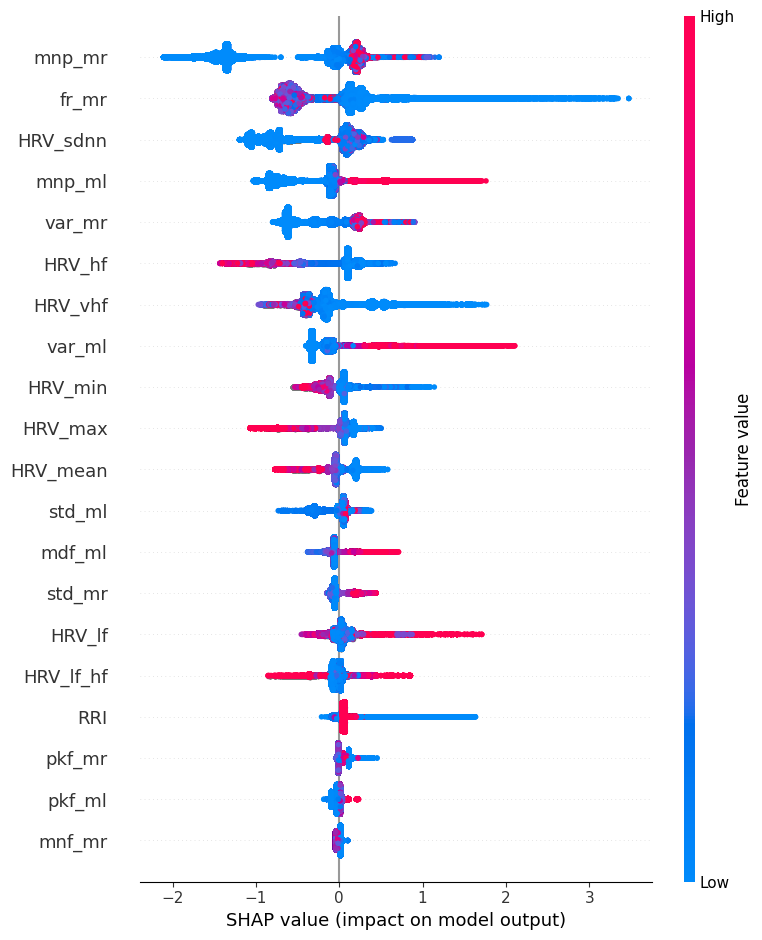

In [10]:
booster = model.get_booster()

dtrain = xgb.DMatrix(X_train)

explainer = shap.TreeExplainer(booster)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=feature_names)

# Functions to prepare ZZM dataset for prediction

In [13]:
def calculate_hrv(ecg_90s):
    ecg_clean = nk.ecg_clean(ecg_90s, sampling_rate=2000)
    ecg_peaks = nk.ecg_findpeaks(ecg_clean, sampling_rate=2000)
    info, r_peaks_corrected = nk.signal_fixpeaks(ecg_peaks, sampling_rate=2000, iterative=False, show=False, method="Kubios")

    hrv = nk.hrv(r_peaks_corrected,sampling_rate=2000, show=False)

    mean = hrv["HRV_MeanNN"][0]
    median = hrv["HRV_MedianNN"][0]
    sdnn = hrv["HRV_SDNN"][0]
    min = hrv["HRV_MinNN"][0]
    max = hrv["HRV_MaxNN"][0]
    vlf = hrv["HRV_VLF"][0]
    vhf = hrv["HRV_VHF"][0]
    lf = hrv["HRV_LF"][0]
    hf = hrv["HRV_HF"][0]
    lf_hf = hrv["HRV_LFHF"][0]


    return mean, median, sdnn, min, max, vlf, vhf, lf, hf, lf_hf

def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def spectrum(signal, sampling_rate):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (sampling_rate / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power


def frequency_ratio(frequency, power):
    # Low range: 1-30 Hz
    power_low = power[(frequency >= 1) & (frequency <= 30)]
    
    # High range: 30-500 Hz
    power_high = power[(frequency > 30) & (frequency <= 500)]

    ULC = np.sum(power_low)
    UHC = np.sum(power_high)

    # Avoid division by zero in case the high-frequency power is 0
    if UHC == 0:
        return np.inf
    else:
        return ULC / UHC

def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]
    
    if den == 0:
        return np.nan
    else:
        return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0
    try:
        while abs(errel) > tol:
            temp += power[i]
            errel = (power_total - temp) / power_total
            i += 1
            if errel < 0:
                errel = 0
                i -= 1

        return frequency[i]
    except:
        return np.nan
    
def peak_freq(frequency, power):
    try:
        return frequency[power.argmax()]
    
    except:
        return np.nan
    

def get_rri(ecg, sampling_rate=2000):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_rate)
    ecg_peaks = nk.ecg_findpeaks(ecg_clean, sampling_rate=sampling_rate)
    info, r_peaks_corrected = nk.signal_fixpeaks(ecg_peaks, sampling_rate=sampling_rate, iterative=False, show=False, method="Kubios")

    # Calculate RR intervals
    rr_intervals = np.diff(r_peaks_corrected) / sampling_rate * 1000

    # Insert fake data point
    rr_intervals_adjusted = np.insert(rr_intervals, 0, rr_intervals[0])

    # Calculate time axis
    time_r_peaks = r_peaks_corrected[1:] / sampling_rate  # Time corresponding to the RR intervals
    time_r_peaks_adjusted = np.insert(time_r_peaks, 0, 0)  # Add a time point for the fake interval
    print(time_r_peaks[0])

    rri_adj_df = pd.DataFrame(data={'RRI': rr_intervals_adjusted, 'RRI_t': time_r_peaks_adjusted})

    return rri_adj_df

# Function to populate the RRI column in df_sliding
def extend_df_with_rri(df_sliding, df_rr):
    # Create a new column to store RR intervals
    df_sliding['RRI'] = np.nan
    
    rri_index = 0  # Pointer for the df_rr
    total_rr_rows = len(df_rr)

    for idx in range(len(df_sliding)):
        # Get the current start time of the sliding window
        window_start = df_sliding.at[idx, 'start_time']
        
        # Update the RRI value until we reach the next RRI_t
        while rri_index < total_rr_rows and df_rr.at[rri_index, 'RRI_t'] <= window_start:
            # Populate the RRI value for this window
            df_sliding.at[idx, 'RRI'] = df_rr.at[rri_index, 'RRI']
            rri_index += 1
        
        # If we have reached the end of RRI DataFrame, we can break
        if rri_index >= total_rr_rows:
            break
    
    # Fill any remaining NaN values in the RRI column with the last known value
    df_sliding['RRI'].fillna(method='ffill', inplace=True)
    
    return df_sliding

In [14]:
def extract_features_for_prediction(sensor_data, window_size_emg_s=1, overlap_emg_s=0.5, window_size_ecg_s=90, overlap_ecg_s=45, sampling_rate=2000):
    window_size_emg = int(window_size_emg_s * sampling_rate)
    window_size_ecg = int(window_size_ecg_s * sampling_rate)
    overlap_emg = int(overlap_emg_s * sampling_rate)
    overlap_ecg = int(overlap_ecg_s * sampling_rate)

    features_1s = []
    features_90s = []

    ecg_data = sensor_data['ECG'].values
    mr_data = sensor_data["MR"].values
    ml_data = sensor_data["ML"].values

    for i in range(window_size_emg, len(sensor_data), overlap_emg):

        # Extract the 1-second window
        mr_window = mr_data[i-window_size_emg:i]
        ml_window = ml_data[i-window_size_emg:i]

        # Standard Deviation
        std_mr = np.std(mr_window)
        std_ml = np.std(ml_window)

        # Variance
        var_mr = np.var(mr_window)
        var_ml = np.var(ml_window)

        frequency_mr, power_mr = spectrum(mr_window, sampling_rate)
        frequency_ml, power_ml = spectrum(ml_window, sampling_rate)
        
        # Frequency power
        fr_mr =frequency_ratio(frequency_mr, power_mr) 
        fr_ml =frequency_ratio(frequency_mr, power_mr)

        # Mean power
        mnp_mr = np.sum(power_mr) / len(power_mr)
        mnp_ml = np.sum(power_ml) / len(power_ml)

        
        # Total power
        tot_mr = np.sum(power_mr)
        tot_ml = np.sum(power_ml)

        #Mean Frequency
        mnf_mr = mean_freq(frequency_mr, power_mr)
        mnf_ml = mean_freq(frequency_ml, power_ml)

        # Median frequency
        mdf_mr = median_freq(frequency_mr, power_mr)
        mdf_ml = median_freq(frequency_ml, power_ml)

        # Peak frequency
        pkf_mr = peak_freq(frequency_mr, power_mr)
        pkf_ml = peak_freq(frequency_ml, power_ml)

        start_time = (i-window_size_emg) / sampling_rate
        end_time = i / sampling_rate
        
        current_features = [start_time, end_time, std_mr, std_ml, var_mr, var_ml, fr_mr, fr_ml, mnp_mr, mnp_ml, tot_mr, tot_ml, mnf_mr, mnf_ml, mdf_mr, mdf_ml, pkf_mr, pkf_ml]
        features_1s.append(current_features)
    

        if i % 10000000 == 0:
            print(f"i: {i}")

    for i in range(window_size_ecg, len(ecg_data), overlap_ecg):
        # Extract 90 seconds of ECG data
        window_90s = ecg_data[i - window_size_ecg:i]  # 90-second window

        mean, median, sdnn, min, max, vlf, vhf, lf, hf, lf_hf = calculate_hrv(window_90s)

        num_1s_windows_in_90s = window_size_ecg // window_size_emg
        for _ in range(num_1s_windows_in_90s):
            features_90s.append([mean, median, sdnn, min, max, vlf, vhf, lf, hf, lf_hf])


    combined_features = [f1 + f28 for f1, f28 in zip(features_1s, features_90s[:len(features_1s)])]

    columns = ["start_time", "end_time", "std_mr", "std_ml", "var_mr", "var_ml",
            "fr_mr", "fr_ml", "mnp_mr", "mnp_ml", "tot_mr", "tot_ml", "mnf_mr",
            "mnf_ml", "mdf_mr", "mdf_ml", "pkf_mr", "pkf_ml", "HRV_mean", "HRV_median", "HRV_sdnn", "HRV_min", 
            "HRV_max", "HRV_vlf", "HRV_vhf", "HRV_lf", "HRV_hf", "HRV_lf_hf"]
    
    features = pd.DataFrame(combined_features, columns=columns)

    rri = get_rri(ecg_data)
    features_rri = extend_df_with_rri(features, rri)
    

    return features_rri




In [49]:
sensor_data = pd.read_csv("C:/Users/eleon/Desktop/SDAP/backend/src/data/p1_wk5-6/0621224cFnorm.csv", usecols=['ECG', 'MR', 'ML'])

In [50]:
features = extract_features_for_prediction(sensor_data)

i: 10000000
i: 20000000
i: 30000000
i: 40000000
i: 50000000
i: 60000000


c:\Python311\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python311\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python311\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for mor

1.551


C:\Users\eleon\AppData\Local\Temp\ipykernel_15056\893168007.py:135: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sliding['RRI'].fillna(method='ffill', inplace=True)
C:\Users\eleon\AppData\Local\Temp\ipykernel_15056\893168007.py:135: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sliding['RRI'].fillna(method='ffill', inplace=True)


In [51]:
features

,start_time,end_time,std_mr,std_ml,var_mr,var_ml,fr_mr,fr_ml,mnp_mr,mnp_ml,...,HRV_median,HRV_sdnn,HRV_min,HRV_max,HRV_vlf,HRV_vhf,HRV_lf,HRV_hf,HRV_lf_hf,RRI
0,0.0,1.0,3.390030,4.073298,11.492305,16.591754,2.092385,2.092385,11.233942,16.218738,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
1,0.5,1.5,0.231922,0.332753,0.053788,0.110725,1.057916,1.057916,0.052581,0.108242,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
2,1.0,2.0,0.433604,0.316314,0.188012,0.100054,1.195433,1.195433,0.183808,0.097842,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
3,1.5,2.5,0.623762,0.233606,0.389079,0.054572,2.287714,2.287714,0.380332,0.053345,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
4,2.0,3.0,0.525776,0.333637,0.276440,0.111314,3.243622,3.243622,0.270268,0.108826,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65965,32982.5,32983.5,0.146941,0.249783,0.021592,0.062392,0.966812,0.966812,0.021110,0.060989,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,421.0
65966,32983.0,32984.0,0.144709,0.246873,0.020941,0.060946,0.805986,0.805986,0.020471,0.059577,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,421.0
65967,32983.5,32984.5,0.138357,0.248639,0.019143,0.061822,0.542370,0.542370,0.018712,0.060432,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,421.0
65968,32984.0,32985.0,0.130668,0.249132,0.017074,0.062067,0.363576,0.363576,0.016694,0.060671,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,2407.5


In [52]:
times = features.iloc[:, 0:2]
features = features.iloc[:, 2:29]

# features.to_csv("C:/Users/eleon/Desktop/0621224cFnorm_features.csv")

In [53]:
features

,std_mr,std_ml,var_mr,var_ml,fr_mr,fr_ml,mnp_mr,mnp_ml,tot_mr,tot_ml,...,HRV_median,HRV_sdnn,HRV_min,HRV_max,HRV_vlf,HRV_vhf,HRV_lf,HRV_hf,HRV_lf_hf,RRI
0,3.390030,4.073298,11.492305,16.591754,2.092385,2.092385,11.233942,16.218738,11492.322503,16591.768960,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
1,0.231922,0.332753,0.053788,0.110725,1.057916,1.057916,0.052581,0.108242,53.790702,110.731748,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
2,0.433604,0.316314,0.188012,0.100054,1.195433,1.195433,0.183808,0.097842,188.035303,100.092331,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
3,0.623762,0.233606,0.389079,0.054572,2.287714,2.287714,0.380332,0.053345,389.079531,54.572190,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
4,0.525776,0.333637,0.276440,0.111314,3.243622,3.243622,0.270268,0.108826,276.484512,111.329029,...,784.0,57.374104,685.0,1011.0,NaN,0.001291,0.021861,0.006245,3.500265,764.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65965,0.146941,0.249783,0.021592,0.062392,0.966812,0.966812,0.021110,0.060989,21.595115,62.391831,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,421.0
65966,0.144709,0.246873,0.020941,0.060946,0.805986,0.805986,0.020471,0.059577,20.941606,60.947306,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,421.0
65967,0.138357,0.248639,0.019143,0.061822,0.542370,0.542370,0.018712,0.060432,19.142660,61.821833,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,421.0
65968,0.130668,0.249132,0.017074,0.062067,0.363576,0.363576,0.016694,0.060671,17.078228,62.066831,...,1234.5,1134.846232,355.0,4699.5,NaN,0.000272,0.067980,0.022228,3.058228,2407.5


## Predict

In [54]:
# Normalize features
features = features.div(features.max(axis=1), axis=0).replace([np.inf, -np.inf], 0)
# features.to_csv("C:/Users/eleon/Desktop/0621224cFnorm_features_normalized.csv")

In [55]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model(f"C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/{model_name}")

In [56]:
y_pred = loaded_model.predict(features)  

y_pred_proba = loaded_model.predict_proba(features)  # Probabilities for each class

print(f"Predicted class labels for new data: {y_pred}")

print(f"Predicted probabilities for new data: {y_pred_proba}")


Predicted class labels for new data: [0 0 0 ... 0 0 0]
Predicted probabilities for new data: [[9.9920595e-01 7.9406315e-04]
 [9.9971861e-01 2.8141093e-04]
 [9.9967802e-01 3.2200979e-04]
 ...
 [9.9984086e-01 1.5914027e-04]
 [9.9985081e-01 1.4916484e-04]
 [9.9985081e-01 1.4916484e-04]]


In [57]:
unique, counts = np.unique(y_pred, return_counts=True)

In [58]:
dict(zip(unique, counts))

{0: 65967, 1: 3}

In [59]:
# Find positions of 1's
indices_of_ones = np.where(y_pred == 1)[0]

print(indices_of_ones)

[13 22 25]


In [60]:
[y_pred_proba[i][1] for i in indices_of_ones]

[0.5823057, 0.53174347, 0.53174347]